# Risk-aware MCTS

In [49]:
import os
import math
import json
import itertools
import numpy as np
import matplotlib
from itertools import product
import matplotlib.pyplot as plt
from tqdm import tqdm

from envs.envs import get_env

import seaborn as sns
sns.set_style("dark")

matplotlib.rcParams['text.usetex'] =  True
plt.rc('text.latex', preamble=r'\usepackage{pifont} \usepackage{amsfonts}')
matplotlib.rcParams.update({'font.size': 16})

sns.set_palette("colorblind")

In [50]:
def calculate_erm(dist, beta):
    return (1.0 / beta) * np.log( (1/len(dist)) * np.sum(np.exp(beta*dist)) )

In [51]:
def cvar_erm(samples: np.ndarray, beta : float, num_resamples: int=25_000):
    # Confidence interval estimation.
    resampled = np.random.choice(samples,
                                size=(len(samples), num_resamples),
                                replace=True).T
    # print("resampled.shape", resampled.shape)
    var_thresholds = np.percentile(resampled, (1-confidence_level) * 100, axis=1)
    # print("var_thresholds", var_thresholds)
    # print("len(var_thresholds)", len(var_thresholds))
    tail_losses_indicators = resampled >= var_thresholds[:, np.newaxis]
    # print("tail_losses_indicators", tail_losses_indicators)
    # print("tail_losses_indicators.shape", tail_losses_indicators.shape)
    resampled[~tail_losses_indicators] = np.nan
    # print("resampled", resampled)
    # print("resampled.shape", resampled.shape)
    cvars = np.nanmean(resampled, axis=1)

    confidence_interval = [np.percentile(cvars, 5),
                            np.percentile(cvars, 95)]

    return confidence_interval

### Four state MDP

In [52]:
exp_steps = 1_000

mcts_planner_paths = {
    0.1: 'four_state_mdp_mcts_gamma_0.9_beta_0.1_2025-11-17-09-39-52',
    0.5: "four_state_mdp_mcts_gamma_0.9_beta_0.5_2025-11-17-11-54-35",
    1.0: "four_state_mdp_mcts_gamma_0.9_beta_1.0_2025-11-17-11-55-49",
    2.0: "four_state_mdp_mcts_gamma_0.9_beta_2.0_2025-11-17-11-56-59",
    3.0: "four_state_mdp_mcts_gamma_0.9_beta_3.0_2025-11-17-11-58-09",
    4.0: "four_state_mdp_mcts_gamma_0.9_beta_4.0_2025-11-17-11-59-18",
    5.0: 'four_state_mdp_mcts_gamma_0.9_beta_5.0_2025-11-17-09-40-38',
}

mcts_planner_data = {}

for erm_beta, mcts_path in mcts_planner_paths.items():
    # Load MCTS planner data and MDP.
    with open("data/" + mcts_path + "/exp_data.json", 'r') as f:
        mcts_plan_data = json.load(f)
        mcts_plan_data = json.loads(mcts_plan_data)
    f.close()
    mcts_planner_data[erm_beta] = mcts_plan_data

# print(mcts_planner_data)

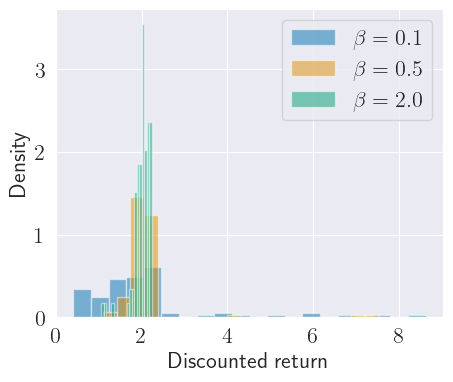

In [53]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

plt.hist(mcts_planner_data[0.1]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.1$')
plt.hist(mcts_planner_data[0.5]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=0.5$')
plt.hist(mcts_planner_data[2.0]["f_vals"], density=True, bins=20, alpha=0.5, label=r'$\beta=2.0$')
plt.ylabel('Density')
plt.xlabel("Discounted return")
plt.grid()

plt.legend()

# plt.savefig("f_dist_entropy_example.pdf", bbox_inches='tight')
plt.show()

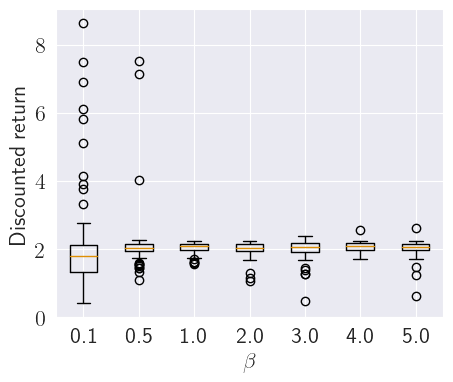

In [54]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

data_to_plot = []
positions = list(range(len(mcts_planner_data)))
for erm_beta, mcts_data in mcts_planner_data.items():
    data_to_plot.append(mcts_data["f_vals"])

plt.boxplot(data_to_plot, positions=positions)
# plt.ylabel('Density')
plt.ylabel("Discounted return");
plt.grid()

plt.xticks(positions, mcts_planner_data.keys())
#plt.xticks(rotation=70)

plt.xlabel(r"$\beta$")

# plt.title(r'$f(d) = d^\top \log(d)$')
# plt.savefig("f_dist_entropy_example.pdf", bbox_inches='tight')
plt.show()

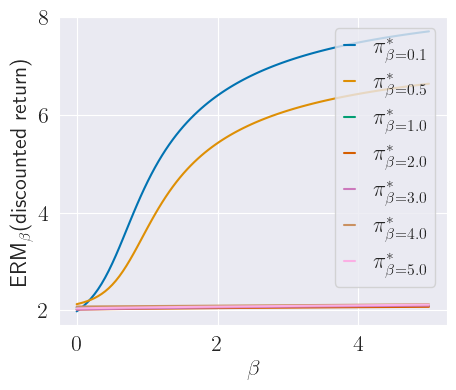

In [55]:
fig = plt.figure()
fig.set_size_inches(5.0, 4.0)
fig.tight_layout()

for erm_beta, mcts_data in mcts_planner_data.items():

    #if erm_beta not in [0.1, 0.95]:
    #    continue

    betas = np.linspace(0.001, 5.0, 100)

    # cis = []
    ys = []
    for beta in betas:
        ys.append(calculate_erm(np.array(mcts_data["f_vals"]), beta=beta))
        #cis.append(cvar_ci(np.array(mcts_data["f_vals"]), confidence_level=alpha, num_resamples=20_000))

    p = plt.plot(betas, ys, label=rf"$\pi^*_{{\beta={erm_beta}}}$")
    
    #cis = np.array(cis)
    #plt.fill_between(alphas, cis[:,0], cis[:,1],
    #                    color=p[0].get_color(), alpha=0.15)
    
plt.xlabel(r'$\beta$')
plt.ylabel(r'ERM$_\beta$(discounted return)')
plt.legend(loc=1, handlelength=0.5)
plt.grid()
#plt.ylim([1,4])
#plt.savefig("cvar_entropy_plot.pdf", bbox_inches='tight')
plt.show()